In [47]:
import json
import pandas as pd

# Load the JSON file
with open("../data/cancel_policy_in_booking.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert into a DataFrame for easier analysis
df = pd.DataFrame(data)
df.head()


,_id,details,no
0,{'$oid': '66ed66ad7403f839a60485d2'},{cancelPolicy=CXL: NO CANCELLATION CHARGE APPL...,104361
1,{'$oid': '66ed66dc7403f839a60485d3'},{cancelPolicy=CXL: NO CANCELLATION CHARGE APPL...,104362
2,{'$oid': '66ee3dde7403f839a60485dc'},{cancelPolicy=CXL: 72H PRIOR OR 1NT FEE/ 1NT D...,104368
3,{'$oid': '66eeb8c03f1d45bc94005075'},{cancelPolicy=CXL: 72H PRIOR OR 1NT FEE/ 1NT D...,104369
4,{'$oid': '66ef769b3f1d45bc94005076'},{cancelPolicy=CXL: CXL 1800 HTL TIME ON 22SEP2...,104370


In [48]:
# Show just the "details" field
df["details"].head(10).tolist()

['{cancelPolicy=CXL: NO CANCELLATION CHARGE APPLIES PRIOR TO 18:00 LOCAL TIME UP\nTO 2 DAYS PRIOR TO ARRIVAL. BEYOND THAT TIME THE FIRST NIGHT\nWILL BE CHARGED.}',
 '{cancelPolicy=CXL: NO CANCELLATION CHARGE APPLIES PRIOR TO 18:00 LOCAL TIME UP\nTO 2 DAYS PRIOR TO ARRIVAL. BEYOND THAT TIME THE FIRST NIGHT\nWILL BE CHARGED.}',
 '{cancelPolicy=CXL: 72H PRIOR OR 1NT FEE/ 1NT DEPOSIT AT BOOKING}',
 '{cancelPolicy=CXL: 72H PRIOR OR 1NT FEE/ 1NT DEPOSIT AT BOOKING}',
 '{cancelPolicy=CXL: CXL 1800 HTL TIME ON 22SEP24-FEE 1 NIGHT-INCL TAX-FEES MUST\nBE CANCELLED BY 6PM LOCAL HOTEL TIME 1 DAY PRIOR TO ARRIVAL TO\nAVOID PENALTY OF 1 NIGHT ROOM AND SERVICE CHARGE.}',
 '{cancelPolicy=CXL: CXL 1800 HTL TIME ON 21SEP24-FEE 1 NIGHT-INCL TAX-FEES MUST\nBE CANCELLED BY 6PM LOCAL HOTEL TIME 1 DAY PRIOR TO ARRIVAL TO\nAVOID PENALTY OF 1 NIGHT ROOM AND SERVICE CHARGE.}',
 '{cancelPolicy=CXL: CXL 1 DAY PRIOR TO ARRIVAL}',
 '{cancelPolicy=CXL: 5616.70 THB CXL FEE PER ROOM CANCELLATION PERMITTED UP TO\n1DAYS

In [54]:
import re
import pandas as pd

# 1) Extract only the cancellationText when present; otherwise return ""
FIELD_CT  = re.compile(r'cancellationText\s*:\s*(.+?)(?=\n(?:isCancellable|cancelDeadline)\b|$)',
                       flags=re.IGNORECASE | re.DOTALL)
HAS_ISCAN = re.compile(r'\bisCancellable\s*:', flags=re.IGNORECASE)
HAS_DEADL = re.compile(r'\bcancelDeadline\s*:', flags=re.IGNORECASE)

def extract_policy(details: str) -> str:
    if not isinstance(details, str):
        return ""
    # normalize newlines & trim
    s = details.replace("\r\n", "\n").replace("\r", "\n").strip()

    # unwrap braces { ... } if present
    if s.startswith("{") and s.endswith("}"):
        s = s[1:-1].strip()

    # REQUIREMENT 1: remove the leading "cancelPolicy=" prefix
    if s.lower().startswith("cancelpolicy="):
        s = s[len("cancelPolicy="):].strip()

    # REQUIREMENT 2: if "cancellationText:" exists, keep only that portion
    m_ct = FIELD_CT.search(s)
    if m_ct:
        return m_ct.group(1).strip()

    # REQUIREMENT 3: if metadata fields exist but no cancellationText -> drop
    if HAS_ISCAN.search(s) or HAS_DEADL.search(s):
        return ""

    # REQUIREMENT 4: otherwise keep the whole remaining string
    return s.strip()


# 2) Normalize (your existing helpers can be reused here)
MONTHS = {"JAN":"01","FEB":"02","MAR":"03","APR":"04","MAY":"05","JUN":"06",
          "JUL":"07","AUG":"08","SEP":"09","OCT":"10","NOV":"11","DEC":"12"}
ISO_TS_RE  = re.compile(r"\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}")
DDMMMYY_RE = re.compile(r"\b(\d{1,2})(JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)(\d{2})(-FEE)?\b", re.I)
SPACES_RE  = re.compile(r"\s+")

def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    s = ISO_TS_RE.sub("ISODATETIME", text)  # mask ISO timestamps
    def repl(m):
        dd, mon, yy, fee = m.group(1), m.group(2).upper(), m.group(3), m.group(4) or ""
        yyyy = 2000 + int(yy)
        return f"{yyyy}-{ {'JAN':'01','FEB':'02','MAR':'03','APR':'04','MAY':'05','JUN':'06','JUL':'07','AUG':'08','SEP':'09','OCT':'10','NOV':'11','DEC':'12'}[mon] }-{dd.zfill(2)}{fee}"
    s = DDMMMYY_RE.sub(repl, s)             # 17JUL25[-FEE] → 2025-07-17[-FEE]
    s = SPACES_RE.sub(" ", s).strip().upper()
    return s

# 3) Apply to your DataFrame
# df = pd.read_json("data/cancel_policy_in_booking.json")  # or however you loaded it
df["cancellationText"] = df["details"].apply(extract_policy)

# Drop rows with no cancellationText
before = len(df)
df = df[df["cancellationText"].str.len() > 0].copy()
after = len(df)
dropped = before - after
print(f"Dropped {dropped} rows with no cancellationText; kept {after} rows.")

# Normalize only the extracted policy sentences
df["normalized"] = df["cancellationText"].apply(normalize_text)
df[["no", "normalized"]].head(50)


Dropped 0 rows with no cancellationText; kept 2704 rows.


,no,normalized
0,104361,CXL: NO CANCELLATION CHARGE APPLIES PRIOR TO 1...
1,104362,CXL: NO CANCELLATION CHARGE APPLIES PRIOR TO 1...
2,104368,CXL: 72H PRIOR OR 1NT FEE/ 1NT DEPOSIT AT BOOKING
3,104369,CXL: 72H PRIOR OR 1NT FEE/ 1NT DEPOSIT AT BOOKING
4,104370,CXL: CXL 1800 HTL TIME ON 2024-09-22-FEE 1 NIG...
5,104371,CXL: CXL 1800 HTL TIME ON 2024-09-21-FEE 1 NIG...
6,104373,CXL: CXL 1 DAY PRIOR TO ARRIVAL
7,104376,CXL: 5616.70 THB CXL FEE PER ROOM CANCELLATION...
8,104377,CXL: 48HRS PRIOR OR 1 NIGHT FEE/ CREDIT CARD REQ
9,104378,CXL: 739.35 SGD CXL FEE PER ROOM CANCELLATION ...


In [55]:
import yaml, re
from collections import Counter

with open("../rules/stopwords.yml", "r", encoding="utf-8") as f:
    sw = yaml.safe_load(f)

EDA_SW = set().union(
    sw["eda_stopwords"]["general"],
    sw["eda_stopwords"]["metadata_fields"],
    sw["eda_stopwords"]["months"],
    sw["eda_stopwords"]["currencies"],
    sw["eda_stopwords"]["units_and_timewords"],
    sw["eda_stopwords"]["hotel_noise"],
)

PARSER_DISPLAY_SW = set(sw["parser_display_stopwords"])

TOKEN_RE = re.compile(r"[A-Z/][A-Z0-9/-]{1,}")

def tokenize(s: str):
    return TOKEN_RE.findall(s)

def tokens_for_eda(s: str):
    return [t for t in tokenize(s) if t not in EDA_SW]

def tokens_for_parser_display(s: str):
    # keep units/currencies, only drop true fillers
    return [t for t in tokenize(s) if t not in PARSER_DISPLAY_SW]

# Example:
# df["eda_tokens"] = df["normalized"].map(tokens_for_eda)
# df["parser_tokens"] = df["normalized"].map(tokens_for_parser_display)

# Frequency table for charts (EDA)
eda_counts = Counter()
for s in df["normalized"]:
    eda_counts.update(tokens_for_eda(s))
eda_counts.most_common(2000)


[('CXL', 5228),
 ('FEE', 1858),
 ('CANCELLATION', 1163),
 ('UP', 1005),
 ('PERMITTED', 935),
 ('CANCEL', 924),
 ('PER', 840),
 ('TAX-FEES', 829),
 ('PENALTY', 760),
 ('STAY', 623),
 ('NIGHT-INCL', 455),
 ('AMOUNT', 444),
 ('FORFEIT', 402),
 ('TAX', 345),
 ('AVOID', 280),
 ('FULL', 242),
 ('MUST', 212),
 ('PLUS', 190),
 ('APPLIES', 188),
 ('NIGHT-EXCL', 188),
 ('FEE/', 187),
 ('REQ', 162),
 ('PCT', 137),
 ('HOTEL', 126),
 ('ONE', 126),
 ('RECEIVED', 113),
 ('STAY-EXCL', 106),
 ('SVC', 105),
 ('HOURS', 102),
 ('STAY-INCL', 99),
 ('EXCLUDING', 99),
 ('RATE', 62),
 ('NON-REFUNDABLE', 50),
 ('ARRIVAL-FEE', 46),
 ('CANCELLATION/AMENDMENT', 44),
 ('ARRIVAL-CXL', 40),
 ('ENTIRE', 38),
 ('DEPOSIT', 34),
 ('WITHIN', 34),
 ('FREE', 31),
 ('ST', 30),
 ('EQUALS', 27),
 ('INCUR', 27),
 ('CANCELS', 23),
 ('CHARGED-CXL', 23),
 ('REFUNDABLE', 21),
 ('ASSESS', 21),
 ('EARLY', 19),
 ('DPST', 19),
 ('CHRG', 18),
 ('RM', 14),
 ('DEPARTURES', 13),
 ('TAX-FEES-NO', 11),
 ('TAX-FEES-', 8),
 ('NON-CANCELLABLE'

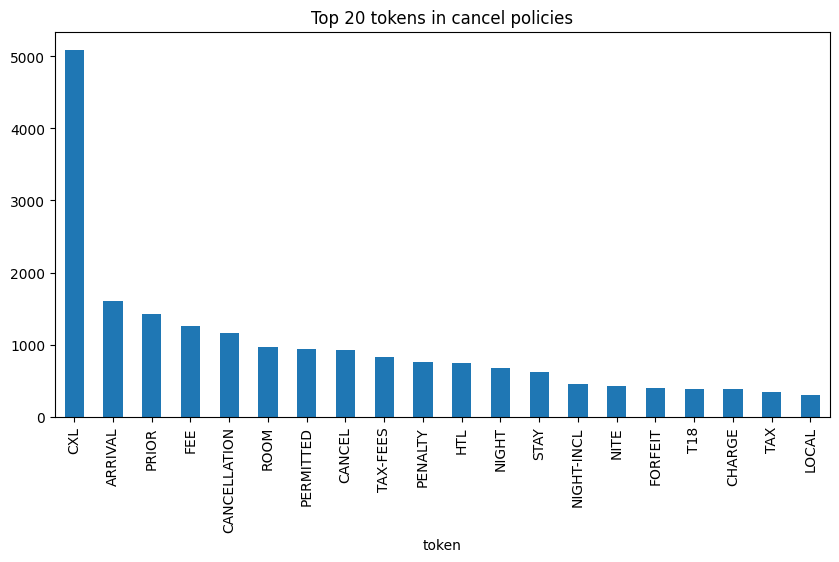

In [56]:
import matplotlib.pyplot as plt

tokens_df = pd.DataFrame(all_tokens.most_common(20), columns=["token","count"])
tokens_df.plot(kind="bar", x="token", y="count", legend=False, figsize=(10,5))
plt.title("Top 20 tokens in cancel policies")
plt.show()